# Implementation of code in book in python
[Neural Networks and Deep Learning](http://neuralnetworksanddeeplearning.com/index.html)

In [1]:
import numpy as np
import torch
from typing import Callable

import matplotlib.pyplot as plt
plt.set_cmap('gray')

<Figure size 432x288 with 0 Axes>

# Resources
- [this colab]()

# Building a simple model without using any pytorch nn module

In [2]:
# compare to https://colab.research.google.com/drive/1HS3qbHArkqFlImT2KnF5pcMCz7ueHNvY?usp=sharing
class Linear:
    def __init__(self, n_in, n_out):
        self.n_in = n_in
        self.b = torch.zeros(n_out)

        # Note that in some of the textbooks and lectures, the weight matrix w is defined in reversed order so 
        # the multiplication should also be rwversed 
        # initialization is important to prevent weights going to zero: this is known as Kaiming / he initializatiom
        self.w = torch.randn(n_in, n_out) * np.sqrt(2. / n_in)

    def __call__(self, x):
        self.x = x    # stored fo backprop
        x_out = x @ self.w  + self.b    
        return x_out

    def backward(self, grad):
        self.grad_w = self.x.T @ grad
        self.grad_b = grad.sum(axis=0)
        self.x_grad = grad @ self.w.T
        return self.x_grad

    def update(self, lr):
        self.w = self.w - lr * self.grad_w
        self.b = self.b - lr * self.grad_b

class Relu:
    def __call__(self, x):
        self.x = x
        self.output = x.clamp_min(0.0)
        return self.output
    
    def backward(self, grad):
      self.grad = (self.x > 0) * grad
      return self.grad

class MSE:
    def __call__(self, y_pred, y_true):
        # save for backprop setp
        self.y_pred = y_pred
        self.y_true = y_true
        return ((y_pred-y_true)**2).mean()

    def backward(self):
        self.grad = 2 * (self.y_pred-self.y_true) / len(self.y_pred)
        return self.grad


class Model:
  def __init__(self, input_dim, num_hidden):
    self.linear1 = Linear(input_dim, num_hidden)
    self.relu = Relu()
    self.linear2 = Linear(num_hidden, 1)
  
  def __call__(self, x):
    l1 = self.linear1(x)
    r = self.relu(l1)
    l2 = self.linear2(r)
    return l2
  
  def backward(self, output_gradient):
    linear2_gradient = self.linear2.backward(output_gradient)
    relu_gradient = self.relu.backward(linear2_gradient)
    linear1_gradient = self.linear1.backward(relu_gradient)
    # print('Model backward', linear2_gradient.shape, relu_gradient.shape, linear1_gradient.shape)
    # import pdb; pdb.set_trace()
    return linear1_gradient

  def update(self, lr):
    self.linear2.update(lr)
    self.linear1.update(lr)

In [3]:
from typing import Callable

def fit(x: np.ndarray, y: np.ndarray, model: Callable, loss: Callable, lr: float, num_epochs: int):
  for epoch in range(num_epochs):
    y_pred = model(x)
    loss_value = loss(y_pred, y)
    print(f'Epoch {epoch}, loss {loss_value}')
    gradient_from_loss = loss.backward()
    model.backward(gradient_from_loss)
    model.update(lr)

## Test the linear layer
For more details, please consider consulting [this colab](https://colab.research.google.com/drive/1HS3qbHArkqFlImT2KnF5pcMCz7ueHNvY?usp=sharing)

torch.Size([50, 1])
torch.Size([1, 1])
x: torch.Size([50, 1]), weights: torch.Size([1, 1]), bias: torch.Size([1]), y: torch.Size([50, 1])
tensor([[3.0941]])
Loss: 118.12754821777344 grad=3.0741186141967773
mean: 1.3900779485702515
x: torch.Size([50, 1]), weights: torch.Size([1, 1]), bias: torch.Size([1]), y: torch.Size([50, 1])
Initial loss: 118.12754821777344
Final loss: 67.86006164550781


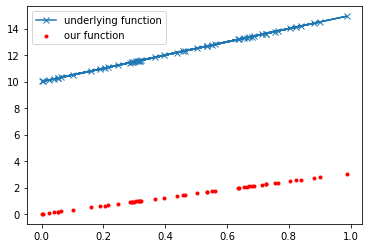

In [4]:
n = 50
d = 1
x = torch.rand(n, d)
print(x.shape)

# y = 5x + 10
weights_true = torch.Tensor(np.array([[5],]))
bias_true = torch.Tensor(np.array([10]))

print(weights_true.shape)
y_true = x @ weights_true + bias_true
print(f'x: {x.shape}, weights: {weights_true.shape}, bias: {bias_true.shape}, y: {y_true.shape}')

linear_layer = Linear(d,1)
loss = MSE()

y_pred = linear_layer(x)

print(linear_layer.w)
print(f'Loss: {loss(y_pred,y_true)} grad={loss.backward().norm()}')
print(f'mean: {y_pred.mean()}')
print(f'x: {x.shape}, weights: {linear_layer.w.shape}, bias: {linear_layer.b.shape}, y: {y_true.shape}')

plt.plot(x, y_true, marker='x', label='underlying function')
plt.scatter(x, y_pred, color='r', marker='.', label='our function')
plt.legend()

y_pred = linear_layer(x)
print(f'Initial loss: {loss(y_pred, y_true)}')
loss_gradient = loss.backward()
linear_layer.backward(loss_gradient)
linear_layer.update(0.1)
y_pred = linear_layer(x)
print(f'Final loss: {loss(y_pred, y_true)}')


## Test A simple model with one hidden layer

In [5]:
loss = MSE()
model = Model(d, 10)
y_pred = model(x)
loss_value = loss(y_pred, y_true)
print(loss_value)
loss_gradient = loss.backward()
model.backward(loss_gradient)
model.update(0.01)
y_pred = model(x)
loss_value = loss(y_pred, y_true)
print(loss_value)

tensor(136.8877)
tensor(112.2447)


## Add uniform random noise

torch.Size([50])
x: torch.Size([50, 1]), weights: torch.Size([1, 1]), bias: torch.Size([1]), y_true: torch.Size([50, 1]), y_train: torch.Size([50, 1])


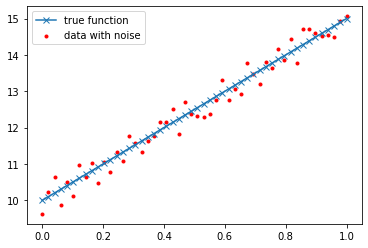

In [6]:
n = 50
d = 1
variance = 0.8
x_train = torch.linspace(0.0, 1.0, n)[:,None]

# y = 5x + 10
weights_true = torch.tensor(np.array([[5],], dtype=np.float32))
bias_true = torch.tensor(np.array([10], dtype=np.float32))
noise = (torch.rand(n)-0.5)*np.sqrt(variance)
print(noise.shape)

y_true = x_train @ weights_true + bias_true
y_train = y_true + noise[:,None]
print(f'x: {x.shape}, weights: {weights_true.shape}, bias: {bias_true.shape}, y_true: {y_true.shape}, y_train: {y_train.shape}')

plt.plot(x_train, y_true, marker='x', label='true function')
plt.scatter(x_train, y_train, color='r', marker='.', label='data with noise')

plt.legend()

## .. and train

In [10]:
loss = MSE()
model = Model(d, 10)
fit(x_train, y_train, model=model, loss=loss, lr=0.001, num_epochs=10000)


Epoch 0, loss 152.64541625976562
Epoch 1, loss 148.83338928222656
Epoch 2, loss 145.1156005859375
Epoch 3, loss 141.48526000976562
Epoch 4, loss 137.934326171875
Epoch 5, loss 134.45001220703125
Epoch 6, loss 131.0279541015625
Epoch 7, loss 127.65666198730469
Epoch 8, loss 124.33444213867188
Epoch 9, loss 121.05146789550781
Epoch 10, loss 117.80260467529297
Epoch 11, loss 114.58970642089844
Epoch 12, loss 111.40544891357422
Epoch 13, loss 108.2477798461914
Epoch 14, loss 105.11443328857422
Epoch 15, loss 102.00553894042969
Epoch 16, loss 98.9233627319336
Epoch 17, loss 95.86537170410156
Epoch 18, loss 92.83025360107422
Epoch 19, loss 89.8204116821289
Epoch 20, loss 86.83634948730469
Epoch 21, loss 83.88006591796875
Epoch 22, loss 80.95382690429688
Epoch 23, loss 78.05902099609375
Epoch 24, loss 75.19744873046875
Epoch 25, loss 72.3727798461914
Epoch 26, loss 69.58838653564453
Epoch 27, loss 66.84648132324219
Epoch 28, loss 64.1500015258789
Epoch 29, loss 61.502132415771484
Epoch 30, lo

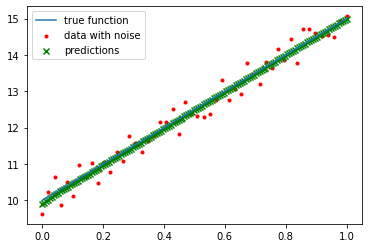

In [11]:
n_pred = 155
x_pred = torch.linspace(0.0,1.0,n_pred)[:,None]
y_pred = model(x_pred)

plt.plot(x_train, y_true, label='true function')
plt.scatter(x_train, y_train, color='r', marker='.', label='data with noise')
plt.scatter(x_pred, y_pred, color='g', marker='x', label='predictions')
plt.legend()

# What's up with those gradients?
The code is ugly as we have to store information for gradients that is used only for training. Pyttorch and other frameworks are based of the concept of `automatic differntiation` ehich handles all of those nasties for you. Pytorch uses the [auto-grad](https://pytorch.org/docs/stable/autograd.html) package for that. For more info look at the [PyTorch Autograd bolg](https://towardsdatascience.com/pytorch-autograd-understanding-the-heart-of-pytorchs-magic-2686cd94ec95).

So if yo consider Pytorch [Linear model](https://pytorch.org/docs/stable/_modules/torch/nn/modules/linear.html#Linear), it looks a lot like the code we wrote above except that the `weight` and `bias` tensors are now wrapped in [Parameter](https://pytorch.org/docs/1.9.1/_modules/torch/nn/parameter.html#Parameter) which, among other things, set the flag `requires_grad` to True, thus allowing auto-grad to track gradients. The gradients stored in the `grad` member.

## Optimization for inference
See the [A GENTLE INTRODUCTION TO TORCH.AUTOGRAD](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#gradients) and the [PERFORMANCE TUNING GUIDE](https://pytorch.org/tutorials/recipes/recipes/tuning_guide.html)

In [12]:
print(model.linear1.w.requires_grad)

False


# Writing the model in the torch way

In [91]:
import torch
import torch.nn as nn

class TwoLayers(nn.Module):
  def __init__(self, input_dim, num_hidden):
    super().__init__()
    self.name = 'TwoLayers'

    self.linear1 = nn.Linear(input_dim, num_hidden)
    self.relu = nn.ReLU()
    self.linear2 = nn.Linear(num_hidden, 1)
  
  def forward(self, x):
    l1 = self.linear1(x)
    r = self.relu(l1)
    l2 = self.linear2(r)
    return l2

class ThreeLayers(nn.Module):
  def __init__(self, input_dim, nh1, nh2):
    super().__init__()
    self.name = 'ThreeLayers'
    self.linear1 = nn.Linear(input_dim, nh1)
    self.relu1 = nn.ReLU()
    self.linear2 = nn.Linear(nh1, nh2)
    self.relu2 = nn.ReLU()
    self.linear3 = nn.Linear(nh2, 1)

  def forward(self, x):
    l1 = self.linear1(x)
    r1 = self.relu1(l1)
    l2 = self.linear2(r1)
    r2 = self.relu2(l2)
    l3 = self.linear3(r2)
    return l3

def many_layers(sizes: list):
    layers = []
    first = sizes[0]
    for s in sizes[1:]:
      layers.append(nn.Linear(first, s))
      layers.append(nn.ReLU())
      first = s
    layers.append(nn.Linear(sizes[-1], 1))
    net = nn.Sequential(*layers)
    return net

def torch_fit(x_train: np.ndarray, y_train: np.ndarray, model: Callable, loss: Callable, lr: float, num_epochs: int, print_every_n_steps: int):
  optimizer = torch.optim.SGD(model.parameters(), lr=lr)
  for epoch in range(num_epochs):
    optimizer.zero_grad()
    y_pred_tensor = model(x_train)
    loss_value = loss(y_pred_tensor, y_train)
    if epoch == 0 or epoch == 100 or epoch == 1000 or epoch == 5000 or epoch == 9500: print(f'Epocj: {epoch} loss={loss_value}')
    loss_value.backward()
    optimizer.step()
  print(f'Epocj: {epoch} loss={loss_value}')

def count_params(model, model_name):
  all_params = sum(p.numel() for p in model.parameters())
  trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
  print(f'Model has total of {all_params}, trainable parameters: {trainable_params}')


def generate_data(model_complexity=1):
  n = 50
  x_train = torch.linspace(0.0, 1.0, n)[:,None]
  if model_complexity==1:
    # y = 5x + 10
    variance = 1.8
    noise = (torch.rand(n)-0.5)*np.sqrt(variance)
    weights_true = torch.tensor(np.array([[5],], dtype=np.float32))
    bias_true = torch.tensor(np.array([10], dtype=np.float32))
    y_true = x_train @ weights_true + bias_true
  elif model_complexity == 2:
    # y = x**2 + 0.5x + 0.3
    variance = 0.1
    noise = (torch.rand(n)-0.5)*np.sqrt(variance)

    x_train = torch.linspace(0.0, 1.0, n)[:,None]
    weights_true = torch.tensor(np.array([[0.5],], dtype=np.float32))
    bias_true = torch.tensor(np.array([10], dtype=np.float32))
    y_true = (x_train-0.5)**2 + x_train @ weights_true + bias_true
  else:
    # y = sin(x) + 0.3
    variance = 0.1
    noise = (torch.rand(n)-0.5)*np.sqrt(variance)

    x_train = torch.linspace(0.0, 1.0, n)[:,None]*3.14159*2.
    weights_true = torch.tensor(np.array([[0.5],], dtype=np.float32))
    bias_true = torch.tensor(np.array([10], dtype=np.float32))
    y_true = torch.sin(x_train) + bias_true
    x_train = x_train / torch.max(x_train)

  y_train = y_true + noise[:,None]
  print(f'x_train: {x_train.shape}, weights: {weights_true.shape}, bias: {bias_true.shape}, y_true: {y_true.shape}, y_train: {y_train.shape}')

  return x_train, y_train, y_true


def draw_data(x_train, y_train, y_true):
  plt.scatter(x_train, y_true, marker='x', label='true function')
  plt.scatter(x_train, y_train, color='r', marker='.', label='data with noise')
  plt.legend()


def draw_results(model, m_name, x_train, y_train, y_true, n_pred=10):
  print(f'Drawe reuslts of model: {m_name}')
  x_pred = torch.linspace(0.0,1.0,n_pred)[:,None]
  y_pred = model(x_pred)

  # Note that y_pred have gradient information, thus we will not be able to display it 
  # In the display function we will use detach to remove the gradient info and allow converting to numpy.
  print(f'Predicting {len(x_pred)} points. y_pred-require-grads={y_pred.requires_grad}')

  plt.plot(x_train, y_true, label='true function')
  plt.scatter(x_train, y_train, color='r', marker='.', label='data with noise')
  plt.scatter(x_pred, y_pred.detach(), color='g', marker='x', label='predictions')
  plt.legend()

# Generating the data
Often will you read in articals teh term `data distribution`. This relates to our perceptual model of the data generation process. We think of a known phenomenom from which we sample the data that we actualy use fo training. Below is out data generation process: We generate the data from three functions corrupted by noise:
- For `model_complexity=1`, we sample from a linear function
- For `model_complexity=2`, we sample from a quadratic function
- For `model_complexity=3`, we sample from a sine function

Of course, in the real world we get only the data and the unxderlying function is only in our imagination. Often we will imagine incorrectly and we need be aware of that and check ourselves repeatidly. 

## Be aware of abuses of referring to those data distribution stuff
See [this tweet](https://twitter.com/yoavgo/status/1481705515122143240?s=27)  by [Yoav Goldberg](https://u.cs.biu.ac.il/~yogo/). People often abuse terms related tp `data distributions` so do not let yourself intimidated by BS written in papers.

x_train: torch.Size([500, 1]), weights: torch.Size([1, 1]), bias: torch.Size([1]), y_true: torch.Size([500, 1]), y_train: torch.Size([500, 1])


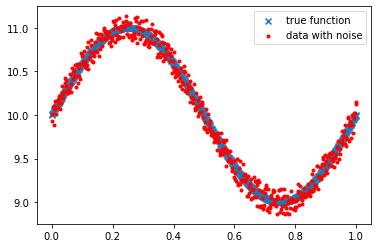

In [87]:
# play with the model complexity = 1,2,3
model_complexity = 3
x_train, y_train, y_true = generate_data(model_complexity=model_complexity)
draw_data(x_train, y_train, y_true)

Model has total of 31, trainable parameters: 31
True
Epocj: 0 loss=89.25865936279297
Epocj: 100 loss=4.141878128051758
Epocj: 1000 loss=0.8474835157394409
Epocj: 4999 loss=0.18656878173351288
Drawe reuslts of model: model_2
Predicting 60 points. y_pred-require-grads=True


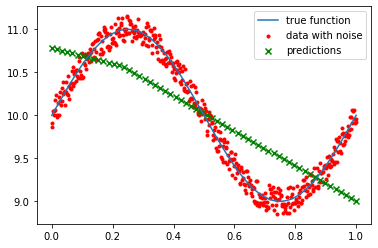

In [95]:
loss = nn.MSELoss()
model_2 = TwoLayers(1, 10)
count_params(model_2, 'model_2')
print(model_2.linear1.weight.requires_grad)

# try learning rate 01, 0.01, 0001
torch_fit(x_train, y_train, model=model_2, loss=loss, lr=0.001, num_epochs=5000,print_every_n_steps=100)
draw_results(model_2, 'model_2', x_train, y_train, y_true, n_pred=60)


Model has total of 261, trainable parameters: 261
Epocj: 0 loss=93.36505126953125
Epocj: 100 loss=0.18600158393383026
Epocj: 1000 loss=0.10885655879974365
Epocj: 4999 loss=0.010894106701016426
Drawe reuslts of model: model_3
Predicting 60 points. y_pred-require-grads=True


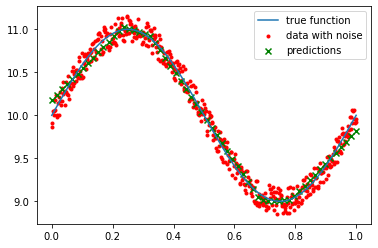

In [93]:
loss = nn.MSELoss()
model_3 = ThreeLayers(1, 20, 10)
count_params(model_3, 'model_3')

# Try learning rates: 0.1, 0.01, 0.001,
torch_fit(x_train, y_train, model=model_3, loss=loss, lr=0.01, num_epochs=5000,print_every_n_steps=100)
draw_results(model_3, 'model_3', x_train, y_train, y_true, n_pred=60)

x_train: torch.Size([500, 1]), weights: torch.Size([1, 1]), bias: torch.Size([1]), y_true: torch.Size([500, 1]), y_train: torch.Size([500, 1])
Model has total of 9361, trainable parameters: 9361
Epocj: 0 loss=98.30208587646484
Epocj: 100 loss=0.21606983244419098
Epocj: 1000 loss=0.11409836262464523
Epocj: 4999 loss=0.029154323041439056
Drawe reuslts of model: model_many
Predicting 60 points. y_pred-require-grads=True


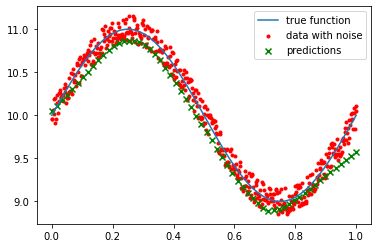

In [96]:
x_train, y_train, y_true = generate_data(model_complexity=model_complexity)

loss = nn.MSELoss()
model_many = many_layers(sizes=[1,100,50,40,30,20,10])

count_params(model_many, 'model_many')

# Try learning rate 0.1, 0.01, 0.001, 0.005
torch_fit(x_train, y_train, model=model_many, loss=loss, lr=0.005, num_epochs=5000, print_every_n_steps=100)
draw_results(model_many, 'model_many', x_train, y_train, y_true, n_pred=60)